Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter, deque
from tqdm import tqdm
import random
import copy
from PIL import Image
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import time
from collections import defaultdict

code_start= time.time()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


File Paths

In [2]:
org_path="/mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/"
# org_path="G:/Projects/Depth_Reconstruction/Test_Folder/stereo_test/"

object_name="Recycle"

test_input_path=org_path+"test_images/"+object_name+"/"
test_output_path=org_path+"test_outputs/"
test_3d_path=org_path+"test_3d/"

left_path = test_input_path+"im0.png"
right_path = test_input_path+"im1.png"
calib_path = test_input_path+"calib.txt"
# test_path= "/mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/test_images/dustbin/im0.png"

Accessory Functions

In [3]:
def load_calibration(file_path):
    
    # {
    #     'cam0': array([[2945.377,    0.   , 1284.862],
    #                 [   0.   , 2945.377,  954.52 ],
    #                 [   0.   ,    0.   ,    1.   ]]),
    #     'cam1': array([[2945.377,    0.   , 1455.543],
    #                 [   0.   , 2945.377,  954.52 ],
    #                 [   0.   ,    0.   ,    1.   ]]),
    #     'doffs': 170.681,
    #     'baseline': 178.232,
    #     'width': 2864,
    #     'height': 1924,
    #     'ndisp': 260,
    #     'isint': 0,
    #     'vmin': 32,
    #     'vmax': 224
    # }
        
    calib = {}
    
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
                
            # Split key and value
            if '=' in line:
                key, value = line.split('=', 1)
                key = key.strip()
                value = value.strip()
                
                # Handle matrix values (e.g., cam0=[...])
                if value.startswith('[') and value.endswith(']'):
                    matrix_str = value[1:-1]
                    # Split rows
                    rows = matrix_str.split(';')
                    matrix = []
                    for row in rows:
                        # Convert each row to float values
                        matrix.append([float(x) for x in row.split()])
                    value = np.array(matrix)
                
                # Handle scalar values
                else:
                    try:
                        # Try to convert to float if possible
                        value = float(value)
                        # Convert to int if no decimal part
                        if value.is_integer():
                            value = int(value)
                    except ValueError:
                        pass  # Keep as string if conversion fails
                
                calib[key] = value
                
    return calib

In [4]:

def load_image_to_rgb(image_path):
    """Load an image from path and return as RGB numpy array."""
    img = Image.open(image_path)
    return np.array(img.convert('RGB'))

In [5]:
def rgb_to_mono(img_array):
    """Convert RGB image array to luminance (grayscale) using standard weights."""
    if len(img_array.shape) == 2:
        return img_array  # Already grayscale
    gray = np.dot(img_array[..., :3], [4, 4, 4])
    return gray.astype(np.int_)

In [6]:

def display_image_array(img_array):
    """Display a numpy image array (2D or 3D) without axes."""
    plt.figure()
    if len(img_array.shape) == 3:  # RGB image
        plt.imshow(img_array)
    else:  # Grayscale
        plt.imshow(img_array/12, cmap='gray')
    plt.axis('off')
    plt.show()

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def display_2x2_grid(images, figsize=(10, 10)):
    
    if len(images) != 4:
        raise ValueError("Exactly 4 images required")
    
    # Create figure and subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.ravel()  # Flatten to 1D array for easy indexing
    
    # Display each image with appropriate colormap
    for i, (img, ax) in enumerate(zip(images, axes)):
        if len(img.shape) == 3:  # RGB image
            ax.imshow(img)
        elif len(img.shape) == 2:  # Grayscale image
            ax.imshow(img/12, cmap='gray')
        else:
            raise ValueError(f"Image {i+1} has invalid shape {img.shape}")
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [8]:


def resize_image_array(image_array, scale_factor):
    # Convert array to PIL Image
    if len(image_array.shape) == 2:
        # Grayscale image
        img = Image.fromarray(image_array)
    elif len(image_array.shape) == 3:
        # RGB/RGBA image
        img = Image.fromarray(image_array.astype('uint8'))
    else:
        raise ValueError("Input array must be 2D (grayscale) or 3D (color)")
    
    # Calculate new dimensions
    width, height = img.size
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)
    
    # Resize using Lanczos resampling (high quality)
    resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Convert back to numpy array
    resized_array = np.array(resized_img)
    
    # Preserve original dtype for grayscale
    if len(image_array.shape) == 2:
        resized_array = resized_array.astype(image_array.dtype)
    
    return resized_array

Plotting Functions

In [9]:
def plot_disp_array(data_array):
    plt.figure(figsize=(8, 6))
    img = plt.imshow(data_array, cmap='viridis')
    plt.axis('off')
    cbar = plt.colorbar(img, fraction=0.046, pad=0.04)
    cbar.set_label('Value Scale', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

In [10]:
def plot_viridis_matrix(matrix):
    # Visualize results
    plt.figure(figsize=(12, 5))
    plt.imshow(matrix, cmap='viridis')
    plt.title('Matrix')
    plt.colorbar()

In [11]:

def plot_colorized_segments(array_2d):
    
    # Calculate value occurrences (excluding zeros from frequency calculation)
    flat_array = array_2d.flatten()
    value_counts = Counter(flat_array)
    unique_values = np.array(sorted(value_counts.keys()))
    
    # Separate zero and non-zero values
    zero_exists = 0 in value_counts
    non_zero_values = unique_values[unique_values != 0] if zero_exists else unique_values
    
    # Create Viridis colormap for non-zero values
    if len(non_zero_values) > 0:
        non_zero_counts = np.array([value_counts[v] for v in non_zero_values])
        norm_counts = (non_zero_counts - non_zero_counts.min()) / (non_zero_counts.max() - non_zero_counts.min() + 1e-10)
        cmap = plt.cm.viridis # type: ignore
        
        # Assign colors (using 0.1-0.9 range of Viridis to avoid extremes)
        color_dict = {val: cmap(0.1 + 0.8*norm_counts[i]) 
                     for i, val in enumerate(non_zero_values)}
    
    # Always set 0 to black
    if zero_exists:
        color_dict[0] = (0, 0, 0, 1)  # Black with full opacity
    
    # Create RGB image
    rgb_image = np.zeros((*array_2d.shape, 3))
    for val in color_dict:
        rgb_image[array_2d == val] = color_dict[val][:3]  # Exclude alpha channel
    
    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # return color_dict  # Optional: return the color mapping

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_edge_matrix(matrix):
    
    rows, cols = matrix.shape
    edge_matrix = np.full(matrix.shape,fill_value=1,dtype=int)
    
    # Define 4-adjacency offsets (up, down, left, right)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    for i in range(rows):
        for j in range(cols):
            current_val = matrix[i, j]
            is_edge = False
            
            # Check all 4 adjacent neighbors
            for di, dj in directions:
                ni, nj = i + di, j + dj
                if 0 <= ni < rows and 0 <= nj < cols:  # Check bounds
                    if matrix[ni, nj] != current_val and edge_matrix[ni, nj] != 0:
                        is_edge = True
                        break
            
            if is_edge:
                edge_matrix[i, j] = 0
                
    
    # Plot the result
    plt.figure(figsize=(10, 10))
    plt.imshow(edge_matrix, cmap='binary', vmin=0, vmax=1)  # 0=white, 1=black
    plt.axis('off')
    plt.show()

Texture Segmentation

In [13]:

def texture_segmentation(image, threshold, disable=False):
    
    h, w = image.shape
    output = np.zeros_like(image, dtype=int)
    texture_label = 1
    texture_dict = defaultdict(list)
    
    # Create list of all possible coordinates
    all_coords = [(y, x) for y in range(h) for x in range(w)]
    random.shuffle(all_coords)  # Randomize processing order
    
    with tqdm(total=h*w, desc="Segmenting Textures", disable=disable) as pbar:
        for y, x in all_coords:
            if output[y, x] != 0:
                pbar.update(1)
                continue
                
            org_value = image[y, x]
            stack = [(y, x)]
            pixels_processed = 0
            
            # Perform flood fill
            while stack:
                cy, cx = stack.pop()
                if output[cy, cx] != 0:
                    continue
                    
                output[cy, cx] = texture_label
                texture_dict[texture_label].append((cy, cx))
                pixels_processed += 1
                
                # Check 4-connected neighbors
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ny, nx = cy + dy, cx + dx
                    if (0 <= ny < h and 0 <= nx < w and 
                        output[ny, nx] == 0 and 
                        abs(int(image[ny, nx]) - int(org_value)) <= threshold):
                        stack.append((ny, nx))
            
            texture_label += 1
            pbar.update(pixels_processed)
    
    return output, texture_dict

Generating Disparity 

In [14]:

def generate_disparity(image_l, image_r, text_dict, search_range):
    
    # Validate inputs
    assert image_l.shape == image_r.shape, "Images must have the same shape"
    h, w = image_l.shape
    disparity = np.zeros((h, w), dtype=int)
    
    # Pre-compute all possible right window shifts
    shifts = np.arange(search_range)
    
    for tex in tqdm(text_dict, desc="Generating Disparity"):
        coords = np.array(text_dict[tex])
        i, j = coords[:, 0], coords[:, 1]
        
        # Compute all possible right windows at once
        j_shifted = j.reshape(-1, 1) - shifts.reshape(1, -1)
        
        # Mask for valid coordinates
        valid_mask = (j_shifted >= 0) & (j_shifted < w)
        all_valid = valid_mask.all(axis=0)
        
        # Initialize SAD values with infinity (for invalid shifts)
        sad_values = np.full(search_range, np.inf)
        
        # Compute SAD only for valid shifts
        for k in np.where(all_valid)[0]:
            right_j = j - k
            # Vectorized SAD computation
            diff = image_l[coords[:, 0], coords[:, 1]] - image_r[coords[:, 0], right_j]
            sad_values[k] = np.mean(np.abs(diff))
        
        # Find best disparity (minimum SAD)
        if not np.all(np.isinf(sad_values)):
            best_disparity = np.argmin(sad_values)
            disparity[coords[:, 0], coords[:, 1]] = best_disparity
    
    return disparity

Post Processing

In [15]:
import numpy as np
from collections import deque

def post_process_texture(disp_matrix, texture, threshold_percent):
    
    if disp_matrix.shape != texture.shape:
        raise ValueError("disp_matrix and texture must have the same shape")
    
    rows, cols = disp_matrix.shape
    processed = np.zeros_like(texture, dtype=bool)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    # Create a view for faster access
    texture_flat = texture.ravel()
    disp_flat = disp_matrix.ravel()
    processed_flat = processed.ravel()
    
    for idx in range(len(texture_flat)):
        if processed_flat[idx]:
            continue
            
        current_texture = texture_flat[idx]
        queue = deque([idx])
        region_indices = []
        
        # BFS using flat indices
        while queue:
            flat_idx = queue.popleft()
            if not processed_flat[flat_idx]:
                processed_flat[flat_idx] = True
                region_indices.append(flat_idx)
                
                # Convert to 2D coordinates for neighbor checking
                x, y = np.unravel_index(flat_idx, (rows, cols))
                
                for dx, dy in directions:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < rows and 0 <= ny < cols:
                        neighbor_idx = np.ravel_multi_index((nx, ny), (rows, cols))
                        if (not processed_flat[neighbor_idx] and 
                            texture_flat[neighbor_idx] == current_texture):
                            queue.append(neighbor_idx) # type: ignore
        
        # Process the region
        if region_indices:
            region_disps = disp_flat[region_indices]
            median_disp = np.median(region_disps)
            threshold = median_disp * threshold_percent
            
            # Vectorized outlier detection and replacement
            outliers = np.abs(region_disps - median_disp) > threshold
            disp_flat[region_indices] = np.where(outliers, median_disp, region_disps)
    
    return disp_matrix

Creating 3D model

In [16]:
def create_depth(image_array, disp_matrix,resize_scale,calib):
    
    baseline = calib['baseline']
    focus = calib['cam0'][0][0]
    doffs = calib['doffs']

    height = image_array.shape[0]
    width = image_array.shape[1]


    xyzrgb = []

    for x in tqdm(range(width),desc="Point Cloud Creation"):
        for y in range(height):
            disp = disp_matrix[y, x]
            
            z = (baseline*focus)/(disp*(1/resize_scale)+doffs)
            z = z*resize_scale
            
            rgb = image_array[y, x]
            xyzrgb.append([x, y, z, rgb[0], rgb[1], rgb[2]])


    return xyzrgb

In [17]:
def point_cloud_to_ply(image_array, disp_matrix, resize_scale, output_path, threshold, calib):
    """
    Converts a structured point cloud text file to a binary_little_endian .ply mesh file using Open3D.
    Faces are only created when all pairwise distances between triangle vertices are < threshold.
    Only one threshold parameter is now used; euclid_threshold is ignored.
    """
    # Load data
    data = create_depth(image_array,disp_matrix,resize_scale,calib)
    
    raw_coords = np.array([p[:3] for p in data])
    raw_colors = np.array([p[3:] for p in data])

    # Deduplicate vertices
    vertex_map = {}
    vertices = []
    color_list = []
    index_lookup = []

    for i in range(len(raw_coords)):
        key = tuple(np.round(raw_coords[i], 5))
        if key not in vertex_map:
            vertex_map[key] = len(vertices)
            vertices.append(raw_coords[i])
            color_list.append(raw_colors[i])
        index_lookup.append(vertex_map[key])

    vertices = np.array(vertices, dtype=np.float64)
    color_list = np.array(color_list, dtype=np.uint8)
    index_lookup = np.array(index_lookup)

    # Infer 2D grid shape
    try:
        diffs = np.diff(raw_coords[:, 1])
        W = np.where(diffs < 0)[0][0] + 1
    except IndexError:
        raise ValueError("Couldn't infer width from data.")

    H = len(raw_coords) // W
    if H * W != len(raw_coords):
        raise ValueError("Point count does not match inferred grid dimensions.")

    index_map = index_lookup.reshape(H, W)

    # Helper to check pairwise distances
    def all_pairwise_within_threshold(p1, p2, p3, max_dist):
        return (
            np.linalg.norm(p1 - p2) < max_dist and
            np.linalg.norm(p2 - p3) < max_dist and
            np.linalg.norm(p3 - p1) < max_dist
        )

    # Grid-based triangle generation
    face_set = set()
    faces = []

    for y in tqdm(range(H - 1),desc="Generating Faces"):
        for x in range(W - 1):
            i1, i2, i3 = index_map[y, x], index_map[y, x + 1], index_map[y + 1, x]
            i4 = index_map[y + 1, x + 1]

            # Triangle 1
            if -1 not in [i1, i2, i3]:
                p1, p2, p3 = vertices[i1], vertices[i2], vertices[i3]
                if all_pairwise_within_threshold(p1, p2, p3, threshold):
                    face = tuple(sorted([i1, i2, i3]))
                    if face not in face_set:
                        face_set.add(face)
                        faces.append(list(face))

            # Triangle 2
            if -1 not in [i2, i4, i3]:
                p1, p2, p3 = vertices[i2], vertices[i4], vertices[i3]
                if all_pairwise_within_threshold(p1, p2, p3, threshold):
                    face = tuple(sorted([i2, i4, i3]))
                    if face not in face_set:
                        face_set.add(face)
                        faces.append(list(face))


    # Construct mesh
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.vertex_colors = o3d.utility.Vector3dVector(color_list.astype(np.float64) / 255.0)

    # Save mesh as binary little endian
    o3d.io.write_triangle_mesh(output_path, mesh, write_ascii=False, compressed=False)
    print(f"Successfully saved mesh at: {output_path}")

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def save_viridis_matrix(matrix, output_path, vmin=None, vmax=None):
    
    # Create figure and axis with no borders
    fig, ax = plt.subplots(figsize=(10, 10), frameon=False)
    ax.set_axis_off()  # Turn off axis
    
    # Normalize data (use input min/max or auto-detect)
    norm = Normalize(vmin=np.min(matrix) if vmin is None else vmin,
                     vmax=np.max(matrix) if vmax is None else vmax)
    
    # Display matrix with Viridis colormap
    plt.imshow(matrix, cmap='viridis', norm=norm)
    
    # Save with tight layout (no padding)
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

def render_object(image_array,disparity,resize_scale,ply_threshold,calib):
    
    height, width, _ = image_array.shape
    
    output_image_path = test_output_path+f"{object_name}_disp_{height}_{width}.png"
    output_3d_path = test_3d_path+f"{object_name}_ply_{height}_{width}.ply"
    
    point_cloud_to_ply(image_array,disparity,resize_scale,output_3d_path,ply_threshold,calib)
    
    save_viridis_matrix(disparity,output_image_path)
    # plt.imshow(disparity)
    # plt.savefig(output_image_path)

Execution

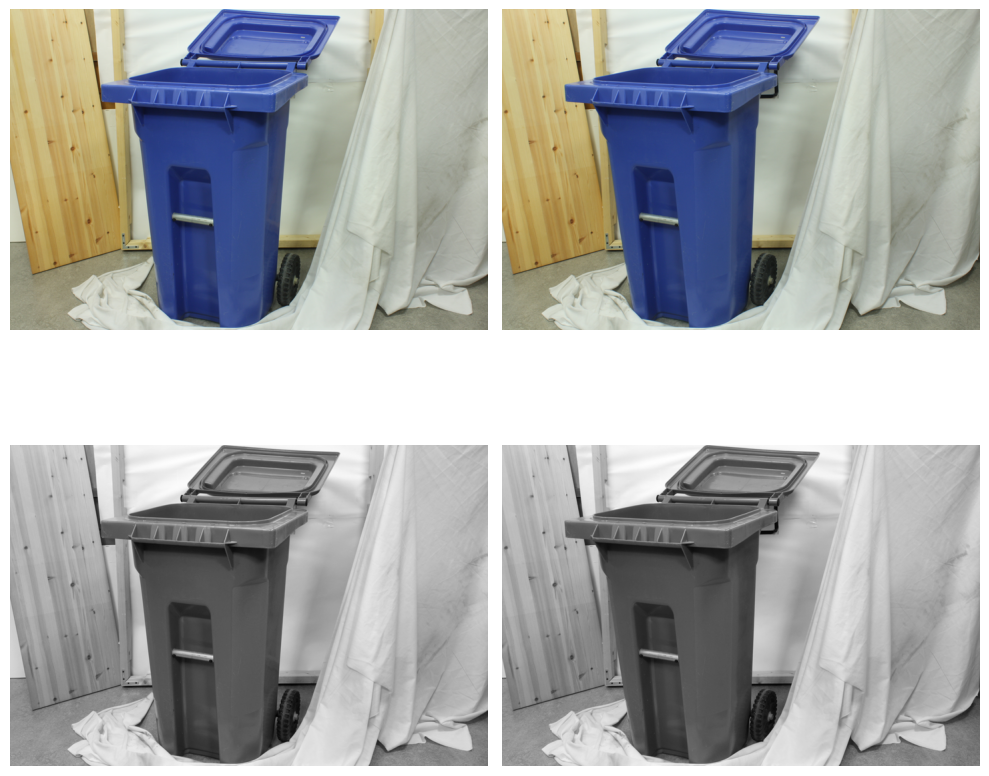

In [19]:
image_array_l = load_image_to_rgb(left_path)
image_array_r = load_image_to_rgb(right_path)
calib_dict = load_calibration(calib_path)


resize_scale = 0.25

rgb_l = resize_image_array(image_array_l,resize_scale)
rgb_r = resize_image_array(image_array_r,resize_scale)

# maximum colour density is now 1020

gray_array_l = rgb_to_mono(rgb_l)
gray_array_r = rgb_to_mono(rgb_r)

display_2x2_grid([rgb_l,rgb_r,gray_array_l,gray_array_r])



In [20]:

print("Image Shape - ",gray_array_l.shape)
print("Total Pixels - ",(gray_array_l.shape[0]*gray_array_l.shape[1]))


Image Shape -  (481, 716)
Total Pixels -  344396


Segmenting Textures: 625820it [00:00, 1041412.15it/s]                           


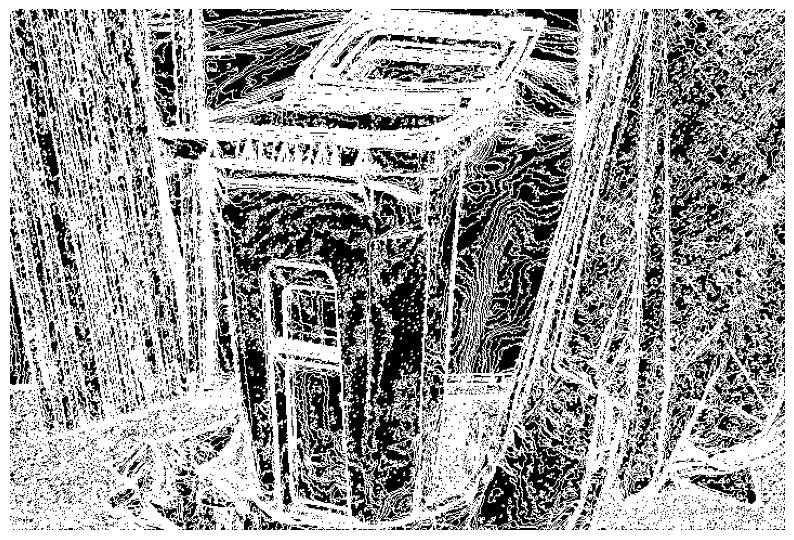

In [21]:
texture,texture_dict = texture_segmentation(gray_array_l,20)

plot_edge_matrix(texture)

Generating Disparity: 100%|██████████| 62972/62972 [00:19<00:00, 3301.84it/s]


Search Distance -  65


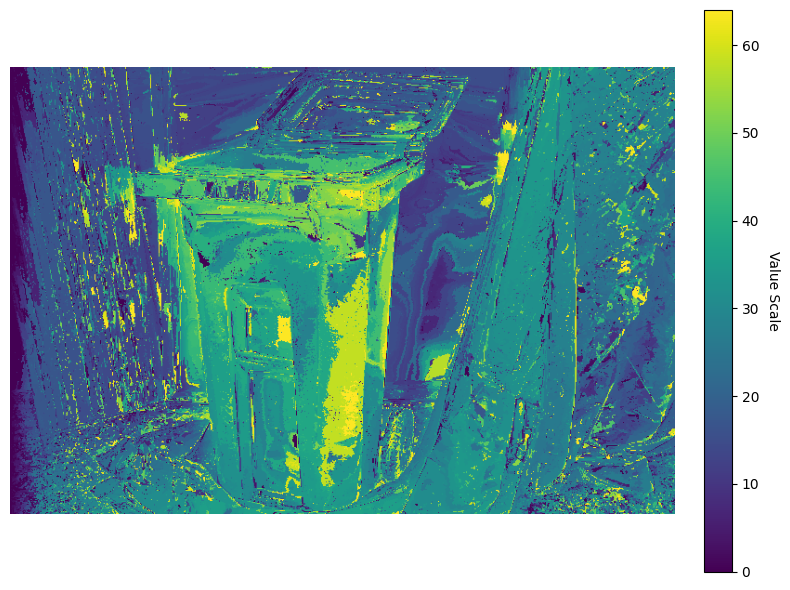

In [22]:
search = round(calib_dict['ndisp']*resize_scale)

disp_matrix = generate_disparity(gray_array_l,gray_array_r,texture_dict,search)

print("Search Distance - ",search)

plot_disp_array(disp_matrix)

# print(disp_matrix)

Post Processing: 100%|██████████| 4/4 [00:12<00:00,  3.06s/it]


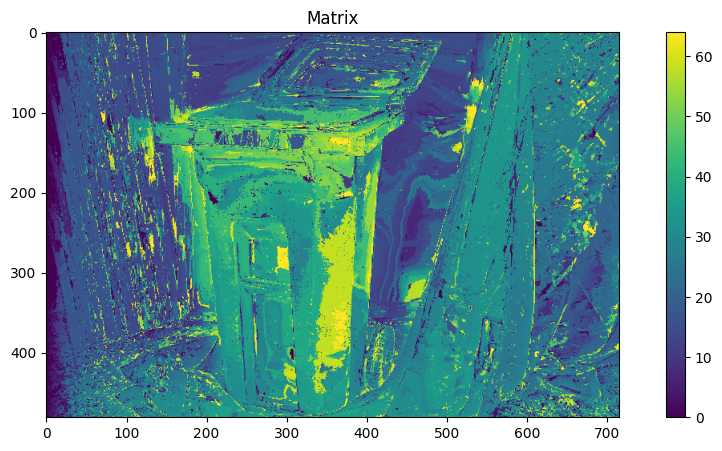

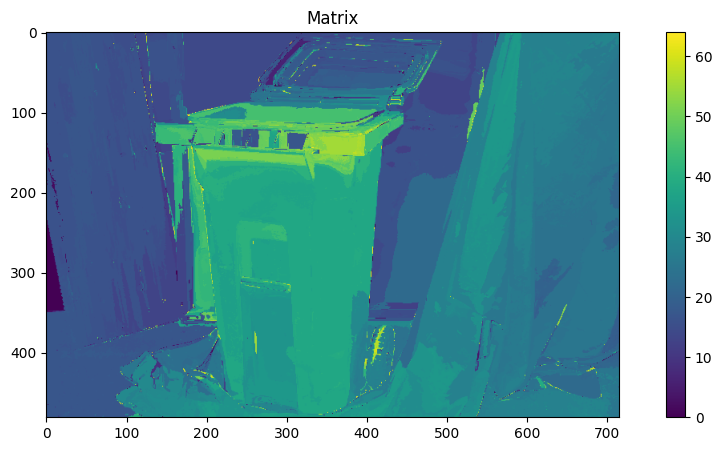

In [23]:
smoothed = copy.deepcopy(disp_matrix)

post_process_iteration = 4

for _ in tqdm(range(post_process_iteration), desc="Post Processing"):
    texture,_ = texture_segmentation(gray_array_l,100,disable=True)
    smoothed = post_process_texture(smoothed,texture, 0.07)

# display_image_array(rgb_l)
plot_viridis_matrix(disp_matrix)
plot_viridis_matrix(smoothed)

In [24]:
render_length = 150 * resize_scale

# render_object(rgb_l,smoothed,resize_scale,render_length,calib_dict)

In [25]:
total_time = time.time()-code_start
print(total_time)

33.62320518493652
